In [1]:
# imports and data collection functions
import requests
def get_usgs_gw1(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s-01-01&endDT=%s-12-31&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()
    #except:
        #return {"error": "Error on USGS access"}
def get_usgs_gw3(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s&endDT=%s&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()

# get daily groundwater value for stations in a state (1900-present) = this gets daily means
def get_usgs_gw2(state, start_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&siteStatus=active&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (start_year, where)
    try:
        req = requests.post(waterservices) 
        return req.json()
    except:
        return {"error": "Error on USGS access 2"}
def get_usgs_gw_code(code, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&sites=%s&startDT=%s-01-01&endDT=%s-12-31&siteStatus=all" % (code, start_date, end_date)
    #waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=%s&&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (code, start_date, end_date)
    #waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=%s&&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (code, start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_rainfall_data(n,s,e,w,start,end):
    # GRID CAN BE prism, goes back to 1981
    # if want to go further back, go back to 1950 with nrcc-nn
    #change nrcc-model to prism or nrcc-nn
    # if i remove county mean it just gives values and not counties
    start2 = f'{start[0:4]}-{start[5:7]}-{start[8:10]}'
    end2 = f'{start[0:4]}-{end[5:7]}-{end[8:10]}'
    input_dict = {"bbox":f"{w},{s},{e},{n}","sdate":f"{start2}","edate":f"{end2}","grid":"nrcc-nn","elems":[{"name":"pcpn","interval":[0,0,1]}]}
    #input_dict = {"bbox":"-75,40,-74,41","sdate":"2023-07-01","edate":"2023-07-07","grid":"nrcc-model","elems":[{"name":"pcpn","interval":[0,0,1],"area_reduce":"county_mean"}]}
    req = requests.post("http://grid2.rcc-acis.org/GridData", json = input_dict)
    data = req.json()
    return data
# Date collection
def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
def get_site_code(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteCode"][0]["value"]
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -99999 and float(get_gw_value(data, site, i)) < 99999:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph

def avg_rainfall_data(data):
    info = []
    for dates in data["data"]:
        accum = 0
        total = 0
        for section in dates[1]:
            for item in section:
                total += item
                accum += 1
        total /= accum
        info.append([dates[0], f'{total:.2f}'])
    return info

In [2]:
# get_station_info(data[], "state", "start_date", "end_date")
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''
def sortkey3(e):
    return e[-2]

def get_station_info(data, start_date, end_date):
    start = dt.datetime(int(start_date), 1, 1)
    end = dt.datetime(int(end_date), 12, 31)
    tot_time = (end - start).days
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        if reps > 500:
            differences = []
            for num in range(reps):
                if num + 1 < reps:
                    value1 = get_gw_date(data, i, num)
                    value2 = get_gw_date(data, i, num + 1)
                    value3 = dt.datetime(int(value1[0:4]), int(value1[5:7]), int(value1[8:10]))
                    value4 = dt.datetime(int(value2[0:4]), int(value2[5:7]), int(value2[8:10]))
                    differences.append([value1, (value4 - value3).days])
            # calculate average duration between each input
            #print(differences)
            curr_category = ''
            category = ''
            temp_list = []
            category_lst = []
            start_d = ''
            for val in differences:
                if val[1] > 0 and val[1] < 4:
                    category = 'daily'
                elif val[1] > 5 and val[1] < 10:
                    category = 'weekly'
                elif val[1] > 25 and val[1] < 35:
                    category = 'monthly'
                else:
                    category = ''
                if curr_category == '':
                    curr_category = category
                    start_d = val[0]
                if category != curr_category:
                    temp_list.append(category)
                    if len(temp_list) == 3:
                        category_lst.append([start_d, val[0], curr_category])
                        curr_category = category
                        start_d = val[0]
                        temp_list = []
            #print(category_lst)
            dailys = 0
            weeklys = 0
            monthlys = 0
            for j in category_lst:
                if j[2] == "daily":
                    dailys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "weekly":
                    weeklys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
                if j[2] == "monthly":
                    monthlys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
            station = get_site(data, i)
            stations.append([i, station ,f'{reps} total entries', get_gw_date(data, i, 0), f"daily for {dailys} total days ({dailys / 365:.1f} years), weekly across {weeklys/7:.1f} weeks ({weeklys/7/52:.1f} years), monthly across approx. {monthlys/30.43:.1f} months"])
    stations.sort(reverse = True, key=sortkey3)
    nums = {}
    for i in stations:
        #print(i)
        print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]})\n\t\t{i[4]}\n')
        nums[get_site_code(data, i[0])] = tot_time - num_of_reps(data, i[0]) -40000
    print(nums)

In [3]:
# graph_comparison(data[], "date", "start_date", "end_date", index_of_site, window_in_wks, if_plotting, percentile) & daily_analysis()
# daily_analysis(graph[], start(dt), end(dt), "date", "end_date", start2(dt))
# change in gw levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np

MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]
# Avg every day
import datetime as dt
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    date_data = []
    for date in list(graph.keys()):
        #print(dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data

def sortkey2(e):
    return e[1]
def graph_comparison2(graph, date, start_date, end_date, index_of_site, window, plotting, percentile):
    graph = show_site_data(graph, index_of_site, False)
    if len(date) == 5:
        date2 = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date2 + dt.timedelta(weeks=-1 * window)
        end = date2 + dt.timedelta(weeks=window,days=-1)
        start2 = date2 + dt.timedelta(weeks=window)
        end2 = date2 + dt.timedelta(weeks=3 * window,days=-1)
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in plottable:
        if plotting:
            dct[(str(i[0]))[2:4]] = i[1]
        else:
            dct[(str(i[0]))] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Streamflow (%s) versus period after" % (date))
        plt.show()
        #for i in dct.keys():
            #print(f'{i}: {dct[i]:.2f}')
    else:
        #print(f'dct is {dct}')
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]
        else:
            return False
        
def graph_comparison(data, date, start_date, end_date, index_of_site, window, plotting, percentile):
    graph = show_site_data(data, index_of_site, False)
    print(data)
    if len(date) == 5:
        date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date + dt.timedelta(weeks=-1 * window)
        end = date + dt.timedelta(weeks=window,days=-1)
        start2 = date + dt.timedelta(weeks=window)
        end2 = date + dt.timedelta(weeks=3 * window,days=-1)
    else:
        start = dt.datetime(int(start_date), int(date), 1)
        end = dt.datetime(int(start_date), int(date), int(MONTH_DATA[int(date) - 1]))
        start2 = end + dt.timedelta(days=1)
        end2 = end + dt.timedelta(days= MONTH_DATA[int(date)] + 1)
    if plotting:
        print(f'Range of data set 1: {start} - {end}\nRange of data set 2: {start2} - {end2}')
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    #print(first_set)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in plottable:
        if plotting:
            dct[(str(i[0]))[2:4]] = i[1]
        else:
            dct[(str(i[0]))] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Groundwater (%s) versus period after" % (date))
        plt.show()
    else:
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]

In [4]:
# percent(data[], "date", "start_date", "end_date", percentile, "state", "station")
NY_STATIONS = [580, 538, 520, 483, 498, 559, 537, 598, 501, 477, 500, 572, 497, 328, 426, 40, 19, 589]
VT_STATIONS = [13, 14]
MA_STATIONS = [90, 165, 163, 119, 150, 144]
ME_STATIONS = [2]
CT_STATIONS = [71, 48, 11, 32, 49, 33, 35, 42, 62, 34]
RI_STATIONS = [3, 5, 4]
def percent(data, date, start_date, end_date, percentile, state, station):
    match state:
        case "NY":
            lookat = NY_STATIONS
        case "VT":
            lookat = VT_STATIONS
        case "MA":
            lookat = MA_STATIONS
        case "ME":
            lookat = ME_STATIONS
        case "CT":
            lookat = CT_STATIONS
        case "RI":
            lookat = RI_STATIONS
    all_stations = []
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    if station == "all":
        for item in lookat:
            one_station = []
            # DO FOR EVERY WEEK OF THE YEAR
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                one_station.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, item, 0.5, False, percentile[0]))
            all_stations.append(one_station)
        for i in all_stations:
            plt.plot(range(52), i, color = (0,0, 1,1))
        plt.title("GW: %s percentile across %s stations" % (percentile[0], state))
    else:
        for i in percentile:
            all_stations = []
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                all_stations.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, int(station), 0.5, False, i))
            plt.plot(range(52), all_stations, color = (i * 0.02,0,1 - i * 0.02,1))
        plt.title("GW: %sth percentile in station %s (%s)" % (percentile, station, get_site(data, int(station))))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    return all_stations

In [5]:
# differences(data[], "date", "start_date", "end_date", index_of_site, week_window_compared) 
# (Utils graph_comparison(), not percent())
# SHOW DIFFERENT WAYS TO CALCULATE DIFFERENCES (Utils graph_comparison(), not percent())
def differences(data, date, start_date, end_date, index_of_site, window):
    PERCENTILES = [5, 10, 25, 33]
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    perm_diff1 = []
    perm_diff2 = []
    perm_diff3 = []
    perm_diff4 = []
    stat_lst = []
    for week in range(int(26 / window)):
        date2 = date + dt.timedelta(days= 7 * week * 2 * window)
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        stats = (graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        diff1 = []
        diff2 = []
        diff3 = []
        diff4 = []
    # [data, mean, median, interquartile range,standard deviation]
        for value in stats[0]:
            diff1.append(value - stats[1])
            diff2.append(value - stats[2])
            diff3.append((value - stats[1])/stats[4])
            diff4.append((value - stats[2])/stats[3])
        # turn into percentiles and put into perm list for each week
        a = list(diff1)
        a = np.array(a)
        b = list(diff2)
        b = np.array(b)
        c = list(diff3)
        c = np.array(c)
        d = list(diff4)
        d = np.array(d)
        perm_diff1.append([np.percentile(a, PERCENTILES[0]),np.percentile(a, PERCENTILES[1]),np.percentile(a, PERCENTILES[2]),np.percentile(a, PERCENTILES[3])])
        perm_diff2.append([np.percentile(b, PERCENTILES[0]),np.percentile(b, PERCENTILES[1]),np.percentile(b, PERCENTILES[2]),np.percentile(b, PERCENTILES[3])])
        perm_diff3.append([np.percentile(c, PERCENTILES[0]),np.percentile(c, PERCENTILES[1]),np.percentile(c, PERCENTILES[2]),np.percentile(c, PERCENTILES[3])])
        perm_diff4.append([np.percentile(d, PERCENTILES[0]),np.percentile(d, PERCENTILES[1]),np.percentile(d, PERCENTILES[2]),np.percentile(d, PERCENTILES[3])])
        stat_lst.append(stats[1:])
    for i in range(len(perm_diff1[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff1)):
            temp.append(perm_diff1[j][i])
            temp2.append(stat_lst[j][0])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 1 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff2[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff2)):
            temp.append(perm_diff2[j][i])
            temp2.append(stat_lst[j][1])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 2 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff3[0])):
        # permdiff3 across all weeks
        temp = []
        temp2 = []
        for j in range(len(perm_diff3)):
            temp.append(perm_diff3[j][i])
            temp2.append(stat_lst[j][3])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.title("GW: difference calculcation 3 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    for i in range(len(perm_diff4[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff4)):
            temp.append(perm_diff4[j][i])
            temp2.append(stat_lst[j][2])
        plt.plot(range(int(26 / window)), temp, color = "green")
        plt.plot(range(int(26 / window)), temp2, color = "blue")
    plt.title("GW: difference calculcation 4 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()

In [6]:
# using_all_weeks(data[], "date", "start_date", "end_date", index_of_site, percent_of_total_outputted)
def sortkey(e):
    return e[0]

def using_all_weeks(data, date, start_date, end_date, index_of_site, percent):
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    window = 0.5
    total_data = []
    for week in range(int(13 / window)):
        #print(week)
        date2 = date + dt.timedelta(weeks= week * 4 * window)
        #print(date2.strftime("%Y/%m/%d"))
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        #print(graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, True, 0))
        info = (graph_comparison2(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        # Need to gather full date of entry
        #ERROR
        if info:
            for i in range(len(info[0])):
                total_data.append([info[0][i],f"{info[7][i]}/{(info[5])} - {info[7][i]}/{info[6]}"])
    total_data.sort(key=sortkey)
    print(str(percent) + "%")
    #print(int(len(total_data)))
    for i in range(int(len(total_data) / (100 / percent))):
        print(f'{total_data[i][0]:.2f}: {total_data[i][1]}')
    
    print(str(100 - percent) + "%")
    for i in total_data[-1 * int(len(total_data) / (100 / percent)): -1]:
        print(f'{i[0]:.2f}: {i[1]}')
    return total_data[0:(int(int(len(total_data) / (100 / percent))))]

In [40]:
# coord_clusters(state)
import math
GOOD_SITES2 = {'425048073472501': 4488, '445052073350201': 4578, '404535073370002': 4731, '404757073440401': 4757, '405027073272602': 4740, '405343073055004': 4755, '431308078544501': 3831, '404932073055902': 4729, '404935073055901': 4756, '403727073154503': 4755, '403533073353202': 4772, '403727073154601': 4762, '404742073410301': 4707, '424158076251901': 4092, '430056075354102': 4648, '422445077203301': 3615, '431030073192101': 4662, '424115073495301': 4357, '414128073475201': 4274, '421556075281602': 4647, '414948074035001': 3941, '404237073433701': 4720, '404609073421602': 4718, '405432073345001': 4778, '404317073291105': 4490, '403517073430702': 4709, '405125073420702': 4598, '410858072171501': 4761, '445216074593001': 4612, '405125073420705': 4750, '404301073240904': 4318, '404619073270601': 4778, '425840077133901': 3015, '424136075025101': 2879, '444904074455201': 2717, '405101073343401': 4671, '403911073432701': 4708, '404030073293703': 4726, '420530078445201': 3272, '405948072172101': 4788, '405309072233101': 4496, '405223072523401': 4338, '405223072523402': 4354, '411802073593001': 3459, '420326079295801': 3301, '430327073475401': 3940, '414737073563301': 3532, '405149072532201': 2779, '404451073475003': 4721, '405010073414901': 4618, '404931073382101': 4762, '405743072425701': 3198, '404812073004101': 4556, '404043073413108': 4449, '404048073412602': 4169, '403929073382908': 4075, '433112075091501': 1903}
GOOD_SITES = {'425048073472501': 4488, '445052073350201': 4578, '404535073370002': 4731, '404757073440401': 4757, '405027073272602': 4740, '405343073055004': 4755, '431308078544501': 3831, '404932073055902': 4729, '404935073055901': 4756, '403727073154503': 4755, '403533073353202': 4772, '403727073154601': 4762, '404742073410301': 4707, '424158076251901': 4092, '430056075354102': 4648, '422445077203301': 3615, '431030073192101': 4662, '424115073495301': 4357, '414128073475201': 4274, '421556075281602': 4647, '414948074035001': 3941, '404237073433701': 4720, '404609073421602': 4718, '405432073345001': 4778, '404317073291105': 4490, '403517073430702': 4709, '405125073420702': 4598, '410858072171501': 4761, '445216074593001': 4612, '405125073420705': 4750, '404301073240904': 4318, '404619073270601': 4778, '425840077133901': 3015, '424136075025101': 2879, '444904074455201': 2717, '405101073343401': 4671, '403911073432701': 4708, '404030073293703': 4726, '420530078445201': 3272, '405948072172101': 4788, '405309072233101': 4496, '405223072523401': 4338, '405223072523402': 4354, '411802073593001': 3459, '420326079295801': 3301, '430327073475401': 3940, '414737073563301': 3532, '405149072532201': 2779, '404451073475003': 4721, '405010073414901': 4618, '404931073382101': 4762, '405743072425701': 3198, '404812073004101': 4556, '404043073413108': 4449, '404048073412602': 4169, '403929073382908': 4075, '433112075091501': 1903}

def sort_by_x(e):
    return e[1][0]
def sort_by_y(e):
    return e[1][1]
def sort_by_distance(e):
    return e[0]
def sort_prox(e):
    return e[1]

def coord_clusters(num_clusters, data):
    # only works for 3 currently, can fix though if desired
    num_of_stations = 3
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        stations.append([i,get_coordinates(data,i)])
    x_lst = stations.copy()
    y_lst = stations.copy()
    x_lst.sort(key = sort_by_x)
    y_lst.sort(key = sort_by_y)
    #print(len(y_lst))
    all_circles = []
    # HOW TO LOCATE 3 CLOSEST WITHOUT ITERATING THROUGH EVERY SINGLE ONE
    for i in range(len(data["value"]["timeSeries"])):
        # GIVES STARTING POINT IN LIST FOR STATION
        x_start = (next((n for n, sublist in enumerate(x_lst) if sublist[0] == i), None))
        y_start = (next((n for n, sublist in enumerate(y_lst) if sublist[0] == i), None))
        # WITH STARTING POINT, START LOOKING IN ALL 4 DIRECTIONS. DO FIRST 3, THEN JUST SWAP OUT LARGEST FOR SMALLER ONE AS PROGRESSES
        accum = 0
        #nearest = []
        nearest_prox = []
        r = 1000

        # min distance searched updates when the difference between whatever direction looking is less than curr value
        # if min distance searched is greater than radii, exit

        points = []
        while True:
            min_distance_searched = 1000
            accum += 1
            #print(accum)
            if x_start + accum < len(data["value"]["timeSeries"]) and x_lst[x_start + accum][0] not in points: # and if not already in list
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start + accum][0], abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][0]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start + accum][0], abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # if r is less than nearest max, add to nearest and remove nearest max
            if x_start - accum >= 0 and x_lst[x_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start - accum][0], abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start - accum][0], abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                #r = abs(nearest[-1][1][0] - x_lst[x_start][1][0]) + abs(nearest[-1][1][1] - x_lst[x_start][1][0])
                # Look down x
            if y_start + accum < len(data["value"]["timeSeries"]) and y_lst[y_start + accum][0] not in points:
                #print(y_start + accum <= len(data["value"]["timeSeries"]))
                #print(len(data["value"]["timeSeries"]))
                if len(nearest_prox) < num_of_stations:       
                    nearest_prox.append([y_lst[y_start + accum][0], abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    #print(y_start + accum)
                    if abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start + accum][0], abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look up y
            if y_start - accum >= 0 and y_lst[y_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([y_lst[y_start - accum][0],abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start - accum][0], abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look down y
            #print((stations[nearest_prox[-1][0]][1]))
            #print(y_lst[y_start][1])
            #print(f'min_distance is {min_distance_searched}')
            #print(f'{nearest_prox} is nearest prox')
            #print(math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2))
            if min_distance_searched > math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2):
                break
        #print(f'{nearest_prox} is nearest prox')
        all_circles.append([math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2), i, nearest_prox[0][0], nearest_prox[1][0], nearest_prox[2][0], get_site_code(data,i), get_site_code(data,nearest_prox[0][0]), get_site_code(data,nearest_prox[1][0]), get_site_code(data,nearest_prox[2][0])])
        #print(all_circles[-1])
    all_circles.sort(key = sort_by_distance)
    #for i in range(num_clusters):
        #print(all_circles[i])
    return all_circles[0:num_clusters]



EXPONENT = 3
MULTIPLIER = 750
DIVIS = 365
REPS_REQUIRED = 999

def coord_clusters2(num_clusters, data, totdays):
    # only works for 3 currently, can fix though if desired
    #goodsites2 = {}
    num_of_stations = 3
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        #goodsites2[get_site_code(data, i)] = totdays.days - reps
        #stations.append([i,get_coordinates(data,i), goodsites2[get_site_code(data,i)]])
        stations.append([i,get_coordinates(data,i), totdays.days - reps])
    x_lst = stations.copy()
    y_lst = stations.copy()
    x_lst.sort(key = sort_by_x)
    y_lst.sort(key = sort_by_y)
    #print(len(y_lst))
    all_circles = []
    # HOW TO LOCATE 3 CLOSEST WITHOUT ITERATING THROUGH EVERY SINGLE ONE
    for i in range(len(data["value"]["timeSeries"])):
    #for i in range(1):
        # GIVES STARTING POINT IN LIST FOR STATION
        x_start = (next((n for n, sublist in enumerate(x_lst) if sublist[0] == i), None))
        y_start = (next((n for n, sublist in enumerate(y_lst) if sublist[0] == i), None))
        # WITH STARTING POINT, START LOOKING IN ALL 4 DIRECTIONS. DO FIRST 3, THEN JUST SWAP OUT LARGEST FOR SMALLER ONE AS PROGRESSES
        accum = 0
        #nearest = []
        nearest_prox = []
        r = 1000

        # min distance searched updates when the difference between whatever direction looking is less than curr value
        # if min distance searched is greater than radii, exit

        points = []
        while True:
            min_distance_searched = 1000
            accum += 1
            #print(accum)
            if x_start + accum < len(data["value"]["timeSeries"]) and x_lst[x_start + accum][0] not in points: # and if not already in list
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # if r is less than nearest max, add to nearest and remove nearest max
            if x_start - accum >= 0 and x_lst[x_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                #r = abs(nearest[-1][1][0] - x_lst[x_start][1][0]) + abs(nearest[-1][1][1] - x_lst[x_start][1][0])
                # Look down x
            if y_start + accum < len(data["value"]["timeSeries"]) and y_lst[y_start + accum][0] not in points:
                #print(y_start + accum <= len(data["value"]["timeSeries"]))
                #print(len(data["value"]["timeSeries"]))
                if len(nearest_prox) < num_of_stations:       
                    nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    #print(y_start + accum)
                    if ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look up y
            if y_start - accum >= 0 and y_lst[y_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
            #print(nearest_prox)
                # Look down y
            #print((stations[nearest_prox[-1][0]][1]))
            #print(y_lst[y_start][1])
            #print(f'min_distance is {min_distance_searched}')
            #print(f'{nearest_prox} is nearest prox')
            #print(math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2))
            if min_distance_searched > math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2):
                break
        #print(f'{nearest_prox} is nearest prox')
        all_circles.append([math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2), i, nearest_prox[0][0], nearest_prox[1][0], nearest_prox[2][0], get_site_code(data,i), get_site_code(data,nearest_prox[0][0]), get_site_code(data,nearest_prox[1][0]), get_site_code(data,nearest_prox[2][0])])
        #print(all_circles[-1])
    all_circles.sort(key = sort_by_distance)
    #for i in range(num_clusters):
        #print(all_circles[i])
    alternate_lst = []
    #print(data)
    for i in all_circles:
        #print(num_of_reps(data, i[1]))
        if num_of_reps(data, i[1]) > REPS_REQUIRED and num_of_reps(data, i[2]) > REPS_REQUIRED and num_of_reps(data, i[3]) > REPS_REQUIRED and num_of_reps(data, i[4]) > REPS_REQUIRED:
            alternate_lst.append(i)
    #print(alternate_lst[0:num_clusters])
    #return alternate_lst[0:num_clusters]

    # do segments of state
    segments = []
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] < -78:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -78 and get_coordinates(data, k[1])[1] < -76:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] > 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] < 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    return segments

In [31]:
# mapping(state, num_clusters)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def mapping(state, num_clusters, data, totdays):
    projection = ccrs.PlateCarree()

    # Set the extent to focus on State (longitude and latitude)
    match state:
        case "NY":
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.747099, -79.901600, 40.450066, 45.104038])
        case "VT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.743431, -73.530463, 42.724495, 45.052165])
        case "MA":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "ME":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-66.868726, -72.033859, 42.955197, 47.488230])
        case "CT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "RI":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "NH":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-70.579929, -72.611172, 42.661347, 45.407703])
    # Add geographical features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Add state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        stations.append([get_coordinates(data,i)[1],get_coordinates(data,i)[0], i])
    lst2 = []
    lst3 = []
    lst = coord_clusters2(num_clusters, data, totdays)
    for i in lst:
        lst3.append(i[1])
        lst2.append(i[2])
        lst2.append(i[3])
        lst2.append(i[4])
    # Plot the points
    stations_2 = []
    stations_3 = []
    for lon, lat, index in stations:
        if index in lst3:
            stations_3.append([lon, lat])
        elif index in lst2:
            stations_2.append([lon, lat])
        else:
            ax.plot(lon, lat, marker='o', color="blue", markersize=1, transform=ccrs.Geodetic())
    for i in stations_2:
        if [i[0], i[1]] not in stations_3:
            ax.plot(i[0], i[1], marker='o', color="red", markersize=2, transform=ccrs.Geodetic())
    for i in stations_3:
        ax.plot(i[0], i[1], marker='o', color="green", markersize=2, transform=ccrs.Geodetic())


    # Save the plot to a file
    plt.title(f'Map of {state}')
    plt.show()
# mapping(state, num_clusters, highlighted, totdays)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def mapping2(state, num_clusters, highlighted, totdays):
    projection = ccrs.PlateCarree()

    # Set the extent to focus on State (longitude and latitude)
    match state:
        case "NY":
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.747099, -79.901600, 40.450066, 45.104038])
        case "VT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.743431, -73.530463, 42.724495, 45.052165])
        case "MA":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "ME":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-66.868726, -72.033859, 42.955197, 47.488230])
        case "CT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "RI":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "NH":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-70.579929, -72.611172, 42.661347, 45.407703])
    # Add geographical features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Add state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    data = get_usgs_gw3(state, "1900-01-01", "2023-12-31")
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        if get_site_code(data, i) in GOOD_SITES:
            stations.append([get_coordinates(data,i)[1],get_coordinates(data,i)[0], i])
    #print(stations)
    lst2 = []
    lst3 = []
    lst = coord_clusters2(num_clusters, data, totdays)
    print(lst)
    for i in lst:
        lst3.append(i[1])
        lst2.append(i[2])
        lst2.append(i[3])
        lst2.append(i[4])
        #print(i)
   # Plot the points
    stations_2 = []
    stations_3 = []
    #print(highlighted)
    highlighted2 = []
    for lon, lat, index in stations:
        if highlighted != None and index in highlighted:
            highlighted2.append([lon, lat])
        elif index in lst3:
            stations_3.append([lon, lat])
        elif index in lst2:
            stations_2.append([lon, lat])
        else:
            ax.plot(lon, lat, marker='o', color="black", markersize=1, transform=ccrs.Geodetic())
    for i in stations_2:
        if [i[0], i[1]] not in stations_3 and [i[0], i[1]]:
            ax.plot(i[0], i[1], marker='o', color="red", markersize=2, transform=ccrs.Geodetic())
    for i in stations_3:
        ax.plot(i[0], i[1], marker='o', color="green", markersize=2, transform=ccrs.Geodetic())
    for i in highlighted2:
        ax.plot(i[0], i[1], marker='o', color="blue", markersize=2, transform=ccrs.Geodetic())
    plt.title(f'Map of {state}')
    plt.show()

In [12]:
# cluster_using_all_wks()
def sort_by_date(e):
     return e[1][0:4]

def cluster_using_all_wks(state, cluster, cluster2, start_date, end_date, percentile):
    data = get_usgs_gw3(state, f"{start_date}-01-01", f"{end_date}-12-31")
    start = dt.datetime(int(start_date), 1, 1)
    end = dt.datetime(int(end_date), 12, 31)
    difference = end - start
    a = coord_clusters2(cluster, data, difference)[cluster2]
    stations = a[5:9]
    nums = a[1:5]
    mapping2(state, cluster, nums, difference)
    lats = []
    longs = []
    comparison = []
    for code in stations:
        data = get_usgs_gw_code(code, start_date, end_date)
        print(f"Station {code}, Coordinates: {get_coordinates(data, 0)}, Number of Values = {num_of_reps(data,0)}")
        # make box for cluster
        lats.append(get_coordinates(data, 0)[0])
        longs.append(get_coordinates(data, 0)[1])
        comparison.append(using_all_weeks(data, "01-01", start_date, end_date, 0, percentile))
    sorted_lst = [[],[],[],[]]
    # calculate box
    s = min(lats)
    n = max(lats)
    e = max(longs)
    w = min(longs)
    for i in range(10):
        for j in range(len(comparison)):
            if comparison != None and len(comparison[j]) > i:
                sorted_lst[j].append(comparison[j][i])
    for item in sorted_lst:
                item.sort(key=sort_by_date)
                #print(f'{comparison[j][i][0]:.2f}, {comparison[j][i][1]}', end = " | ")
        #print("", end ="\n")
    tot_years = {}
    for i in range(len(sorted_lst)):
        for j in sorted_lst[i]:
            if j[1][0:4] not in tot_years:
                tot_years[j[1][0:4]] = [f'{i}: {j[1][5:12]} {j[1][18:]}: {j[0]:.2f}']
            else:
                tot_years[j[1][0:4]].append(f'{i}: {j[1][5:12]} {j[1][18:]}: {j[0]:.2f}')
    for item in tot_years.items():
        if len(item[1]) > 1:
            print(f'{item[0]}: {item[1]}')
              
    # gather all years that have this data into list
    # iterate through and make empty space if empty year or year
    for i in range(10):
        for j in range(len(comparison)):
            if len(comparison[j]) > i:
                print(f'{sorted_lst[j][i][0]:.2f}, {sorted_lst[j][i][1]}', end = " | ")
        print("", end ="\n")
        if i < 2:
            station1 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[0][i][1][:10],sorted_lst[0][i][1][13:]))
            station2 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[1][i][1][:10],sorted_lst[1][i][1][13:]))
            station3 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[2][i][1][:10],sorted_lst[2][i][1][13:]))
            station4 = avg_rainfall_data(get_rainfall_data(n,s,e,w,sorted_lst[3][i][1][:10],sorted_lst[3][i][1][13:]))
            for j in range(len(station1)):
                print(f'{station1[j]}            |{station2[j]}            |{station3[j]}            |{station4[j]}')

[[0.752452836560305, 543, 580, 602, 544, '420326079295801', '424136075025101', '425840077133901', '420530078445201'], [0.752452836560305, 544, 580, 602, 543, '420530078445201', '424136075025101', '425840077133901', '420326079295801'], [0.576165407983875, 563, 632, 580, 602, '422445077203301', '433112075091501', '424136075025101', '425840077133901'], [1.373518697106902, 581, 632, 641, 580, '424158076251901', '433112075091501', '444904074455201', '424136075025101'], [0.8347122477033904, 632, 641, 362, 580, '433112075091501', '444904074455201', '405149072532201', '424136075025101'], [2.144363977632402, 641, 632, 362, 580, '444904074455201', '433112075091501', '405149072532201', '424136075025101'], [0.19952923097032182, 464, 632, 641, 362, '405743072425701', '433112075091501', '444904074455201', '405149072532201'], [1.18570320330362, 520, 632, 641, 362, '411802073593001', '433112075091501', '444904074455201', '405149072532201']]


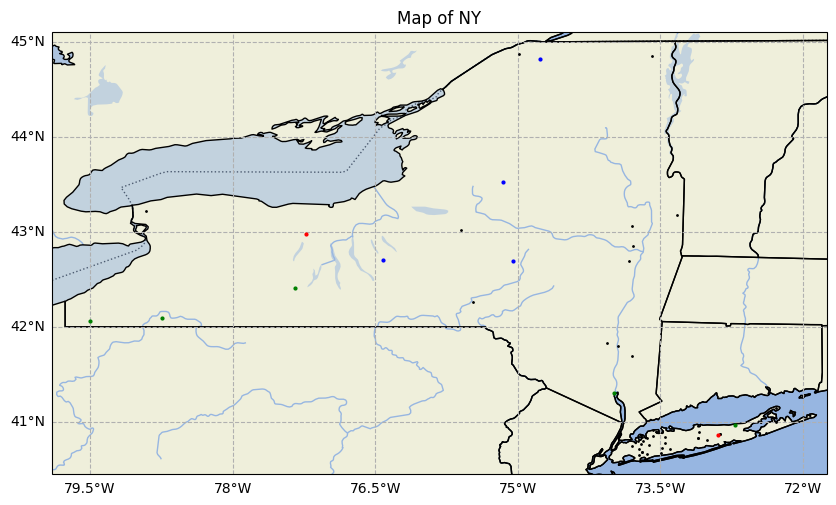

Station 424158076251901, Coordinates: [42.69952778, -76.4216111], Number of Values = 1197
2%
-2.60: 1971/01/25 - 1971/02/07
-2.50: 1971/08/23 - 1971/09/05
-2.50: 1971/09/20 - 1971/10/03
-1.88: 1971/09/06 - 1971/09/19
-1.84: 1984/07/26 - 1984/08/08
-1.83: 1977/10/18 - 1977/10/31
-1.81: 1970/05/31 - 1970/06/13
-1.78: 1984/07/12 - 1984/07/25
98%
2.38: 1971/11/29 - 1971/12/12
2.38: 1972/09/20 - 1972/10/03
2.43: 1981/09/06 - 1981/09/19
2.49: 1972/06/14 - 1972/06/27
2.49: 1988/07/12 - 1988/07/25
2.84: 1976/02/08 - 1976/02/21
3.46: 1984/08/09 - 1984/08/22
Station 433112075091501, Coordinates: [43.5203333, -75.1539722], Number of Values = 3386
2%
-1.66: 1973/08/23 - 1973/09/05
-1.63: 1951/05/17 - 1951/05/30
-1.62: 1988/07/26 - 1988/08/08
-1.52: 1990/05/31 - 1990/06/13
-1.50: 1937/03/08 - 1937/03/21
-1.48: 1943/06/14 - 1943/06/27
-1.47: 1976/04/05 - 1976/04/18
-1.46: 1978/05/31 - 1978/06/13
-1.46: 1984/06/28 - 1984/07/11
-1.42: 1976/05/31 - 1976/06/13
-1.40: 1965/07/26 - 1965/08/08
-1.36: 1941/

In [42]:
# Control Panel
import statistics as stats
state = "NY"

# Year analysis begins
start_date = "1900"

# Year analysis ends
end_date = "2023"

# Specific date start ("01-05" for Jan 1 - Dec 31)
date = "01-05"

# Distance in weeks looked in each direction of date 
window_in_wks = 2

# determines which percentile is graphed, can be list of multiple percentiles
percentile = [5]

cluster = 2
scope = 2

#data = get_usgs_gw3(state, "1950-01-01", "2023-12-31")
#data = get_usgs_gw_code('420530078445201', start_date, end_date)
#print(num_of_reps(data, 27))
#graph_comparison(data, date, start_date, end_date, 615, window_in_wks, True, percentile)
#percent(data, "01-05", start_date, end_date, percentile, state, "all")
#percentile = [5,10,25,33]
#a = percent(data, "01-05", start_date, end_date, percentile, state, "580")
#using_all_weeks(data, date, start_date, end_date, 0, 2)
#differences(data, "01-14", start_date, end_date, 615, window_in_wks)
#get_station_info(data, start_date, end_date)
percent = 2
cluster_using_all_wks(state, cluster, 3, start_date, end_date, percent)
#mapping2(state, 3, [632, 641, 362, 580], dt.datetime(int(end_date), 12, 31) - dt.datetime(int(start_date), 1, 1))